In [11]:
import re
from glob import iglob, glob
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.stats import sigma_clip
import warnings
from lightkurve import MPLSTYLE, LightkurveWarning
from lightkurve import open as open_lc
from lightkurve.utils import running_mean as RunningMean
import numpy as np
from scipy.signal import argrelmax
from scipy.stats import median_absolute_deviation
from LCFeatureExtraction import error_estimate, amplitude_estimate
from usefulFuncs import decode_filename, ifind_tpfs
# from k2spin import prot

## Light Curve Feature Exploration

In this notebook I will be exploring the the distribution of the metrics (or features) that I indent to use for assesing quality of light curve. This is the initial step into coming up with a way of automating my aperture-selection method for the TESS light curves. Also, I want to get a feeling of what the values should look like for different light curves, and how the "good" light curves look like according to my metrics.

First I simply grab all my Light Curves, and setup a few things...

In [17]:
# Parameters
outlier_sigma = 3.0

# Import target list
targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

# Get filepaths to LightCurve FITS
src_lcfs = 'LightCurvesFITS/*.fits'
fits_paths = glob(src_lcfs)

# Get sample target pixel file
sample_tpf = next(ifind_tpfs())

# Get quality mask
with fits.open('DataInput/ClusterQuality/Sector8_Sample.fits.gz') as quality_sample:
    # For Chelsea's quality flags:
    #   0 means good, 1 means bad
    quality_flags = quality_sample[1].data['quality']
    good_mask = ~quality_flags.astype(bool)

Test a light curve that has an obvious signal. This informs me of the type of values I should get, and helps me associate them with the visual representation of the light curve.

Sigma 	= 505.7 ppm
SNR 	= 63.006


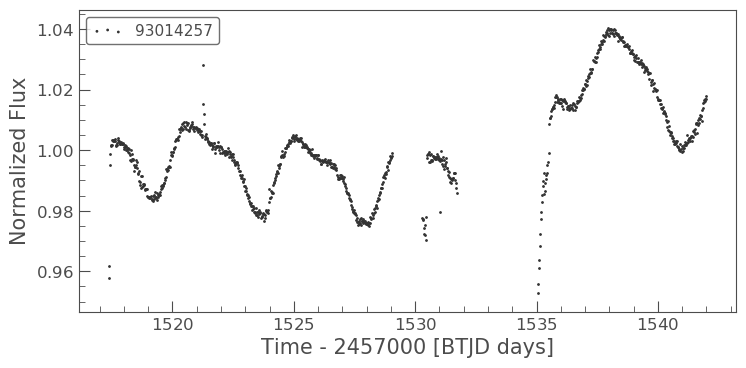

In [8]:
for fits_path in fits_paths:
    if '93014257' in fits_path:
        break

# Import sample FITS Light Curve, remove outliers, and long term trends
ticid, ap_type = decode_filename(fits_path)
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX').normalize()
cleared_lc, clipped_mask = lc.remove_outliers(sigma=outlier_sigma, return_mask=True)

# Estimate Features
sigma = error_estimate(cleared_lc, quality=good_mask[~clipped_mask])
amplitude = amplitude_estimate(cleared_lc, quality=good_mask[~clipped_mask])
print(f'Sigma \t= {sigma*1e6:.1f} ppm')
print(f'SNR \t= {amplitude/sigma:.3f}')
cleared_lc.scatter(normalize=False)

Estimate the features of all my light curves; all three aperture-method light cuves for each of my targets

In [14]:
sigmas = np.zeros(len(fits_paths))
amplitudes = np.zeros(len(fits_paths))

for i, fits_path in enumerate(fits_paths):
    # Import and Prepare light curve
    ticid, ap_type = decode_filename(fits_path)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",category=LightkurveWarning)
        lightcurve, clipped_mask = open_lc(fits_path).get_lightcurve('FLUX').normalize().remove_outliers(sigma=outlier_sigma, return_mask=True)
    
    sigmas[i] = error_estimate(lightcurve, quality=good_mask[~clipped_mask]) * 1e6
    amplitudes[i] = amplitude_estimate(lightcurve, quality=good_mask[~clipped_mask]) / (sigmas[i] / 1e6)

### Distribution of features
The following plot gives an insight into the distribution of my features. We can see there is a widespread of SNR estimates, while most of my noise estimates are lie between ~500-2500 ppm. The axis are setup in a way that the light curves with the best detactable signal should lie on the upper right corner, while the least detactable should lie on the bottom left corner. However, the SNR estimate is not very comprehensive, and should not be trusted very much.

Upper Right corner - Best
Lower left corner - Worst


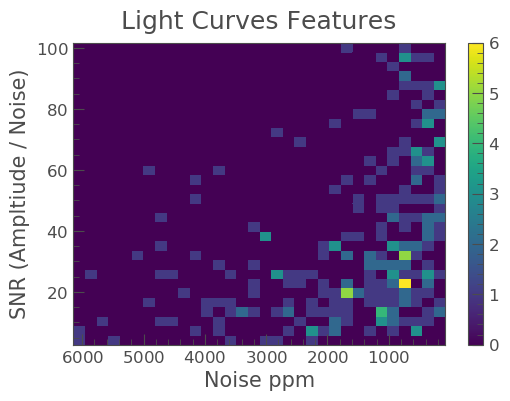

In [15]:
# Plot frequency distribution using histogram
clipped_sigmas = sigma_clip(sigmas, sigma=3)
clipped_amplitudes = sigma_clip(amplitudes)
outliers = clipped_amplitudes.mask | clipped_sigmas.mask
index = np.where(outliers)[0]

with plt.style.context(MPLSTYLE):
    plt.figure(figsize=(6,4))
    plt.hist2d(sigmas[~outliers], amplitudes[~outliers], bins=32)
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    plt.title("Light Curves Features")
    plt.xlabel('Noise ppm')
    plt.ylabel('SNR (Ampltiude / Noise)')
    plt.margins(0)
    plt.colorbar()

    # Display the histogram
    print('Upper Right corner - Best')
    print('Lower left corner - Worst')
    plt.show()

We can then look at some of those light curves on the top - right corner, and see what makes them better than the rest of the light curves.

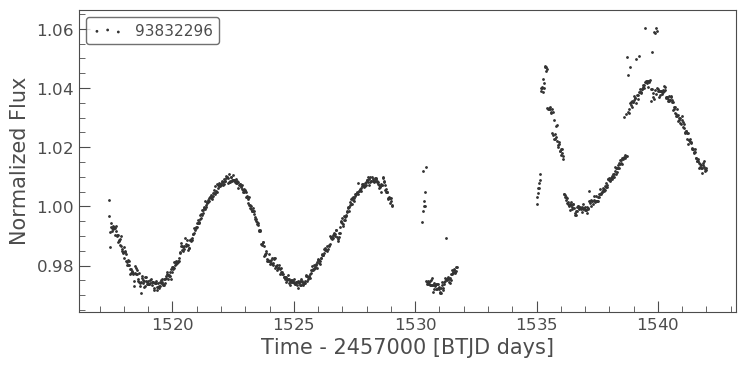

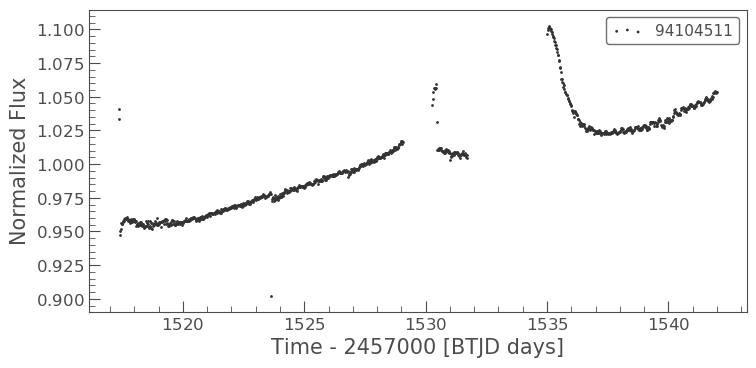

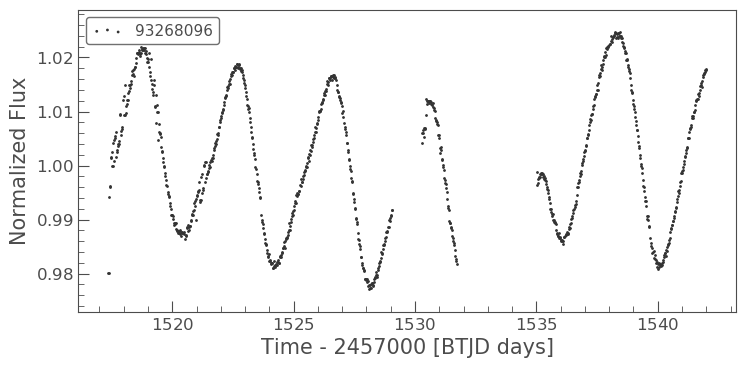

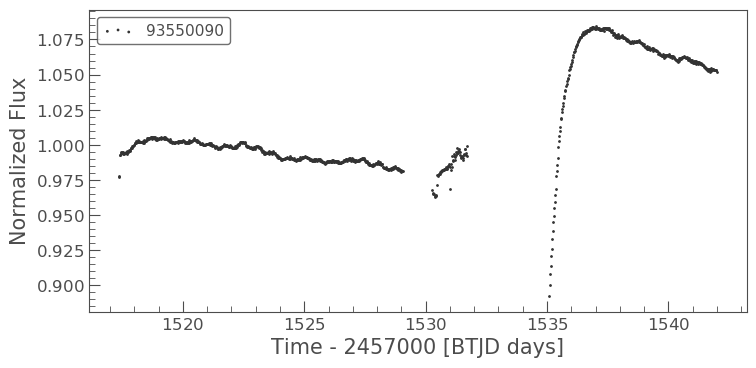

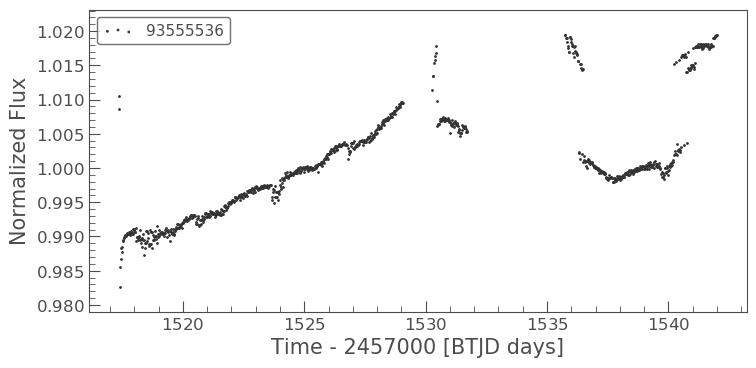

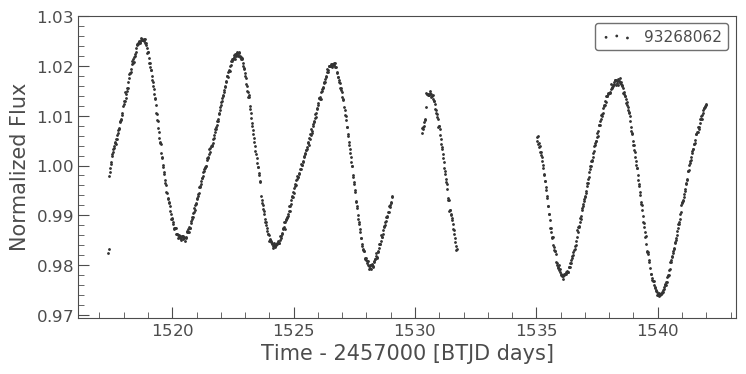

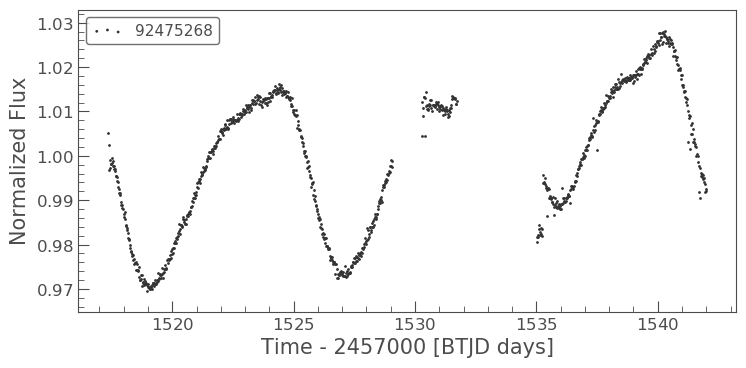

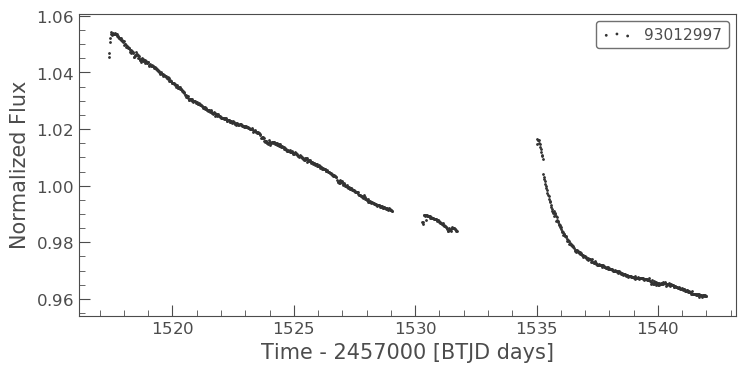

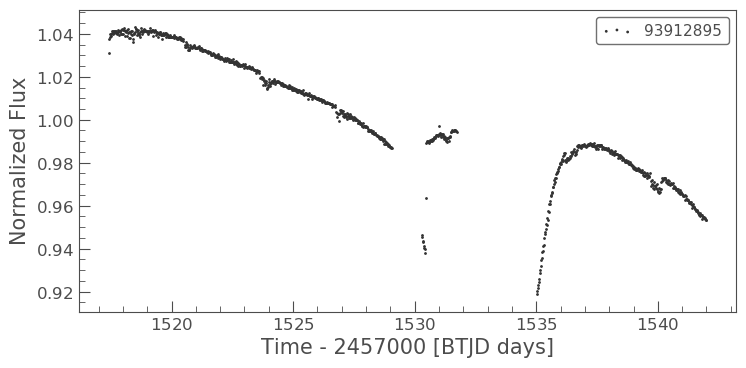

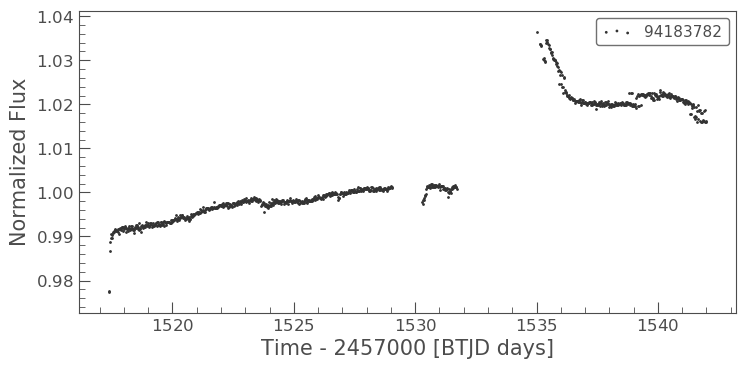

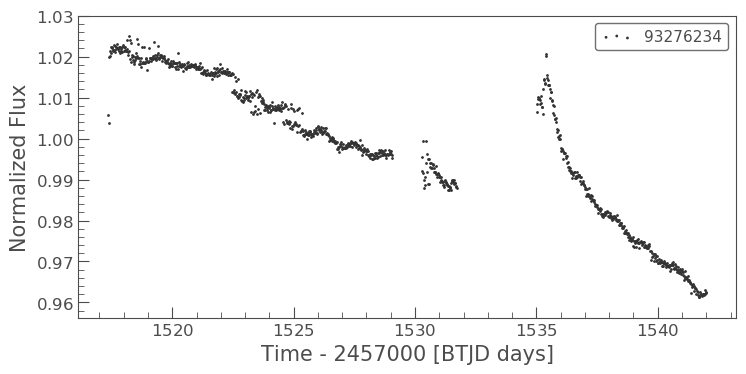

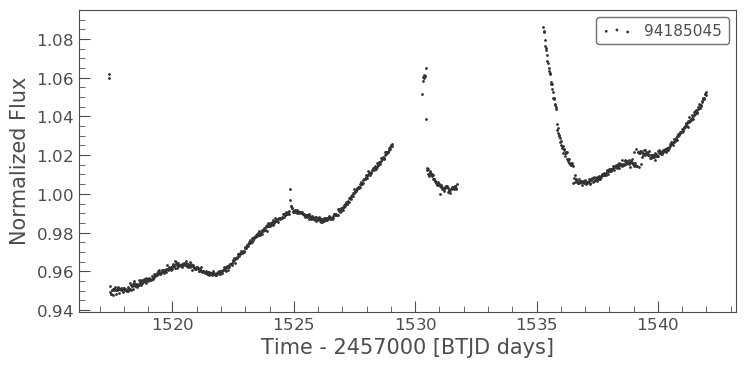

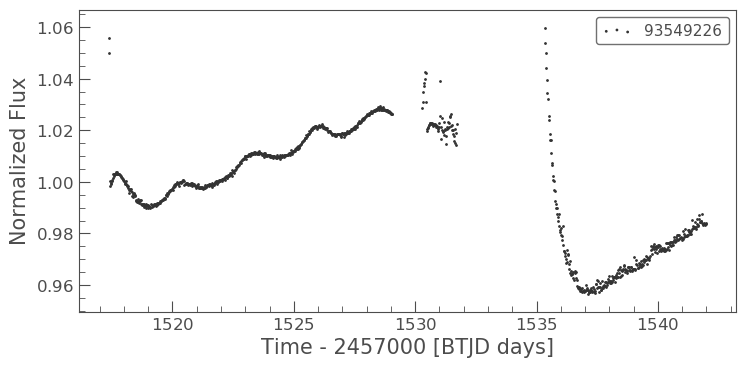

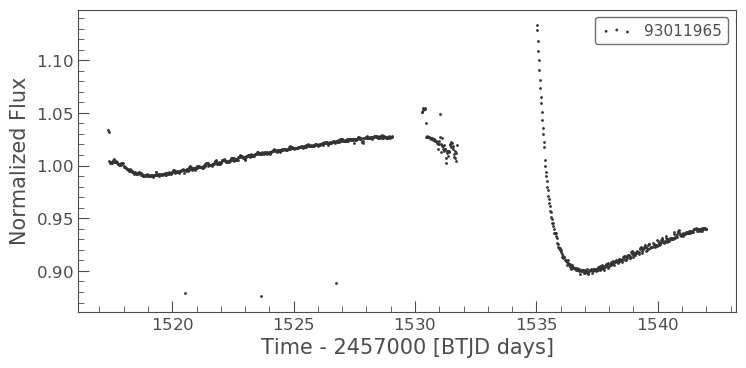

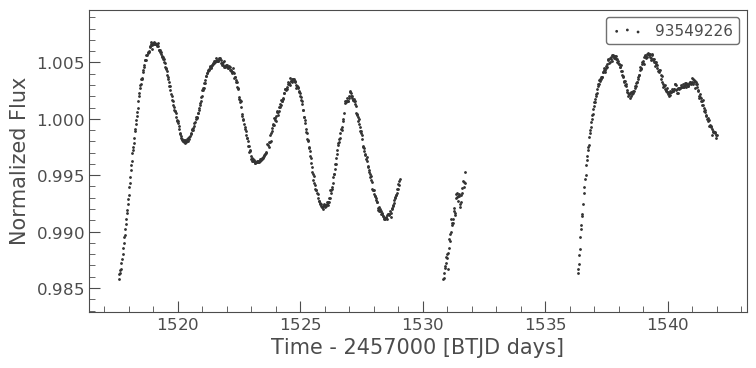

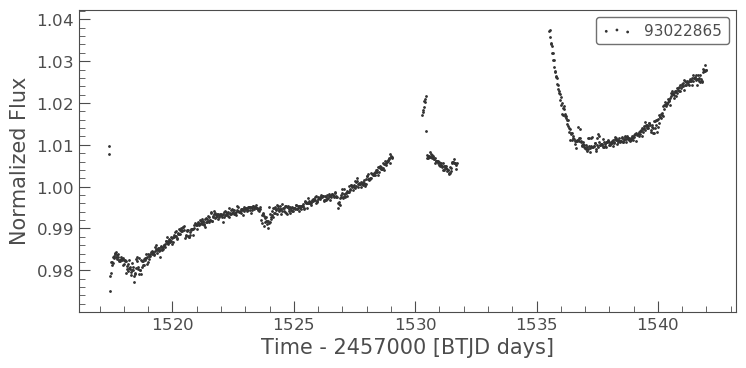

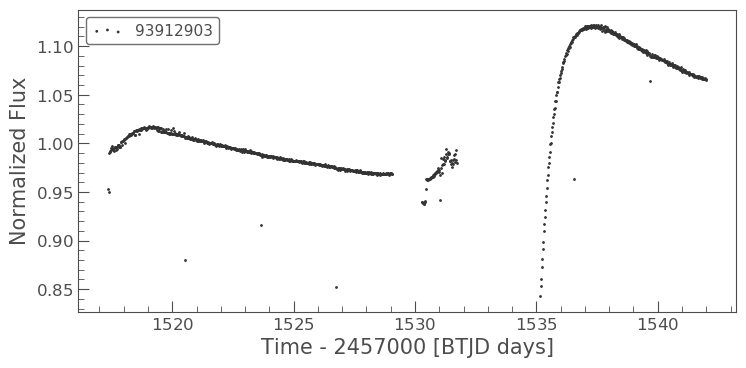

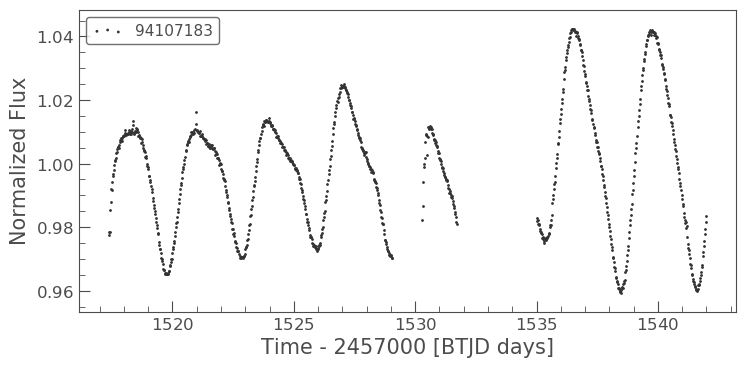

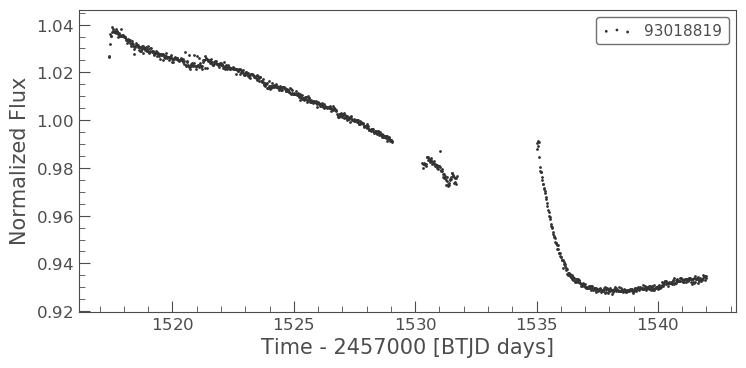

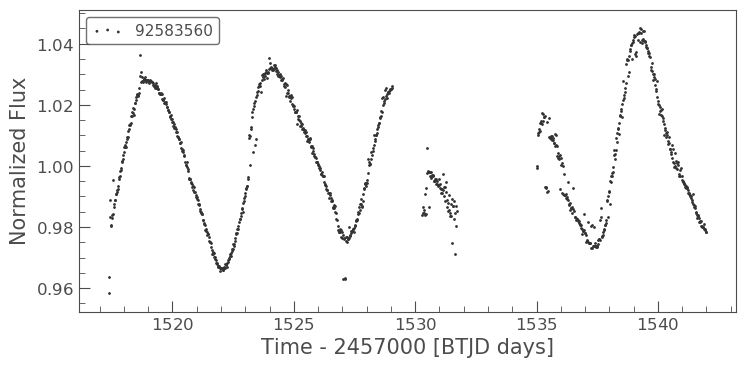

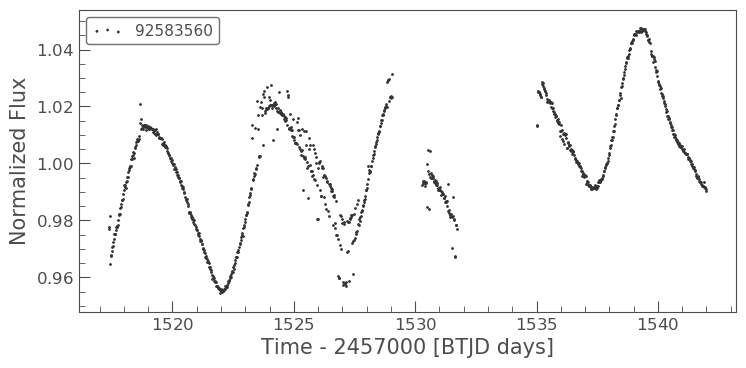

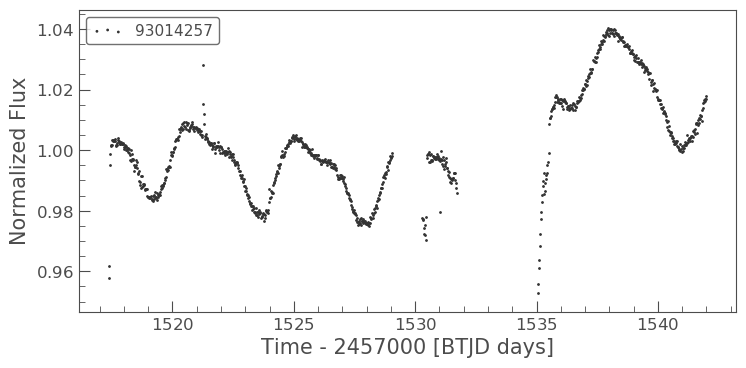

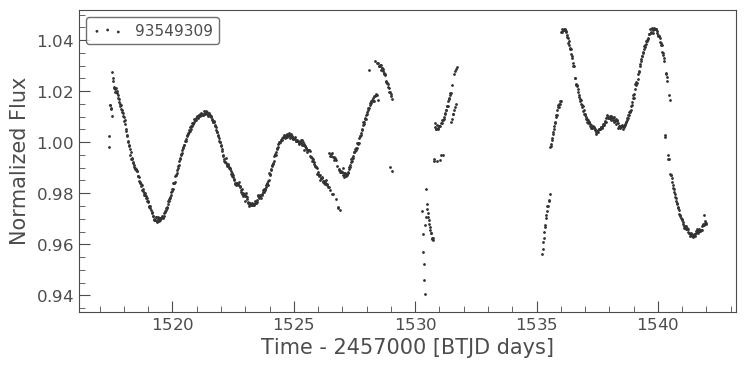

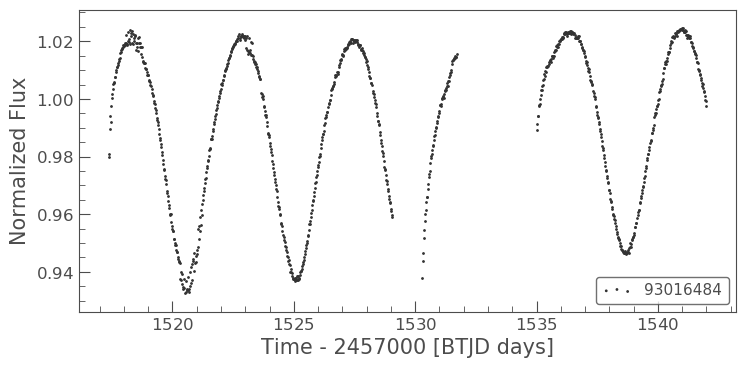

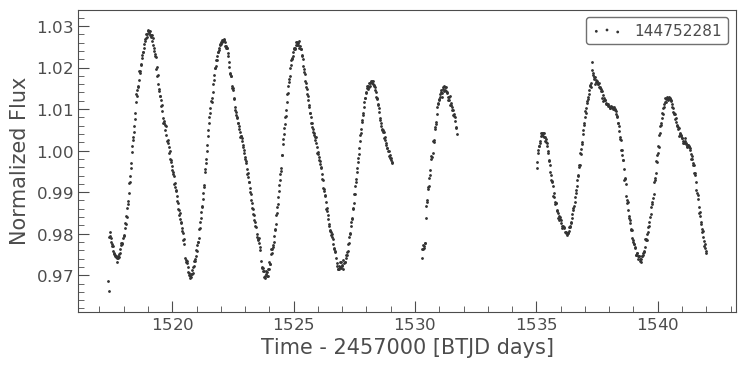

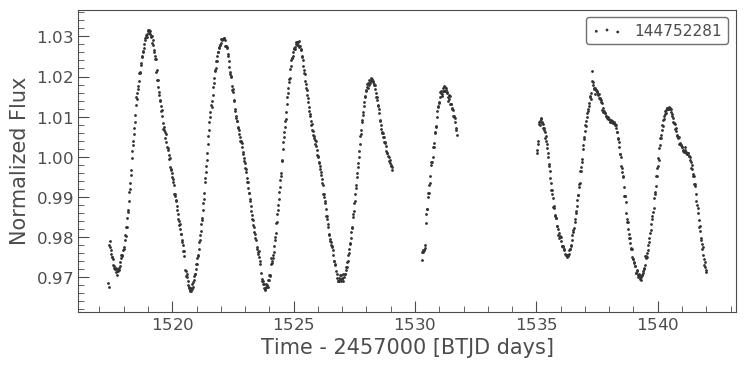

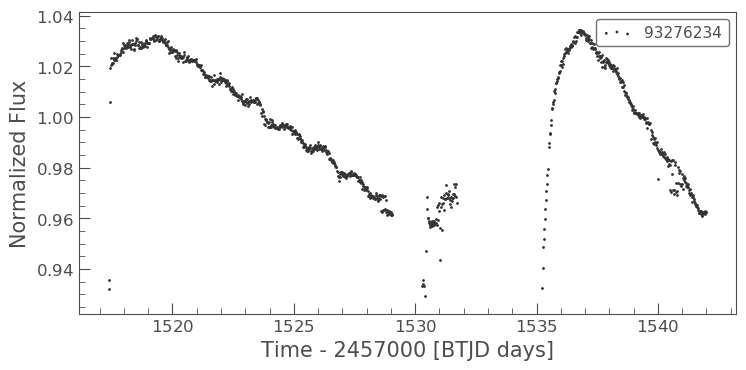

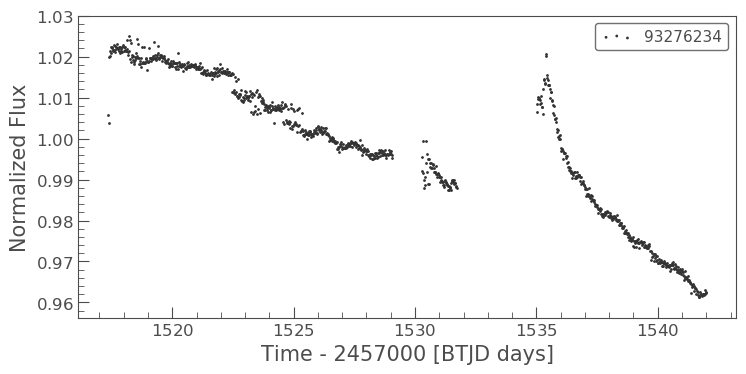

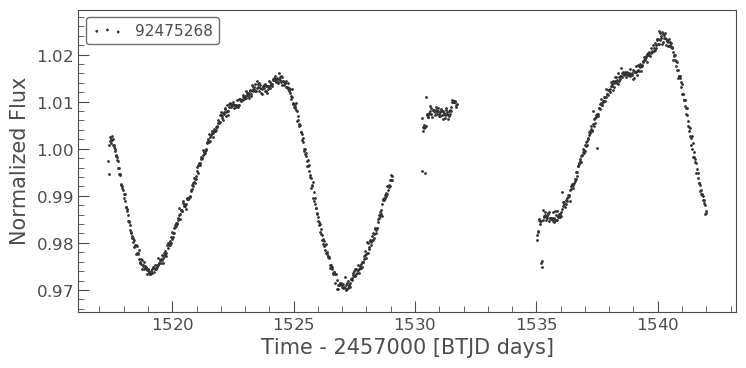

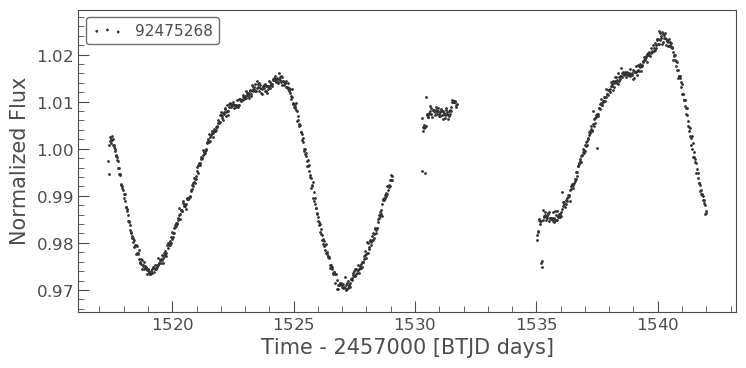

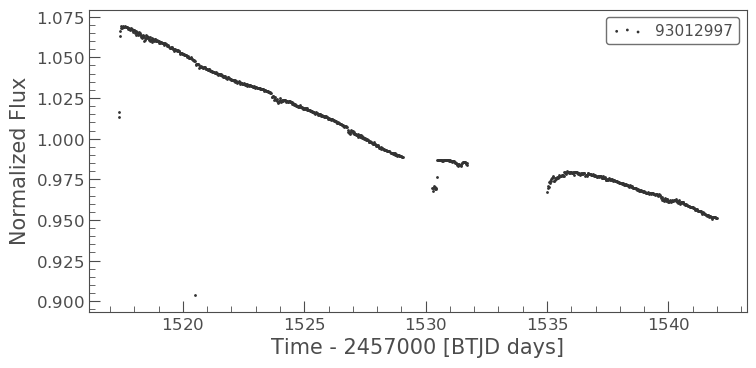

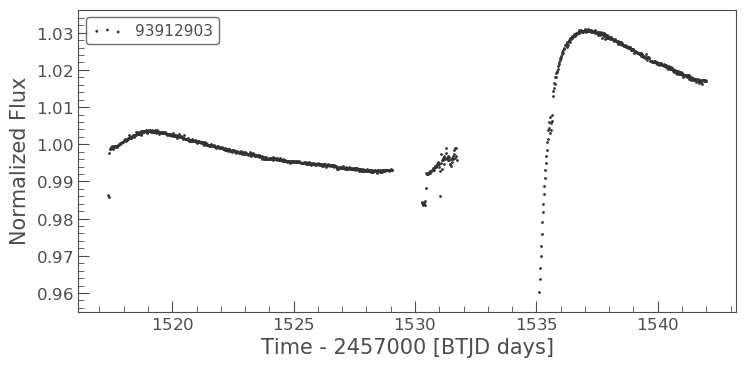

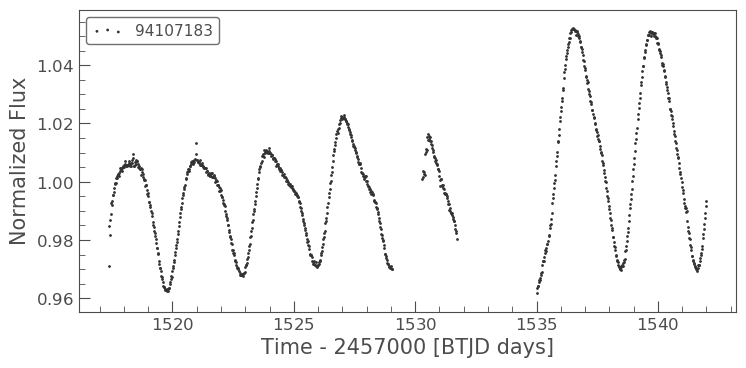

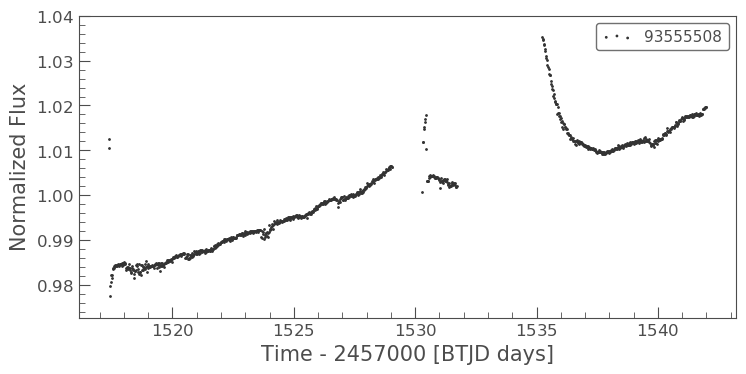

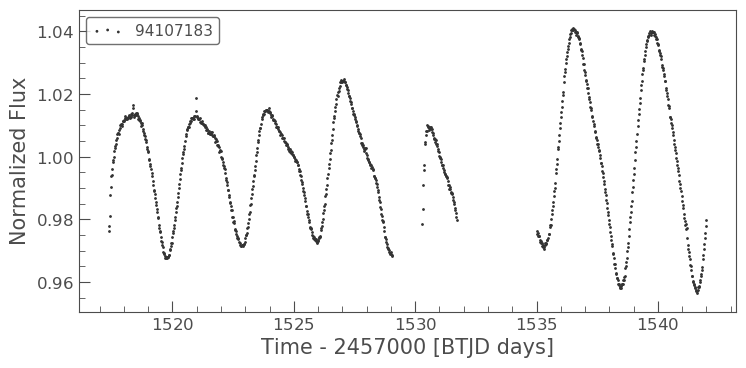

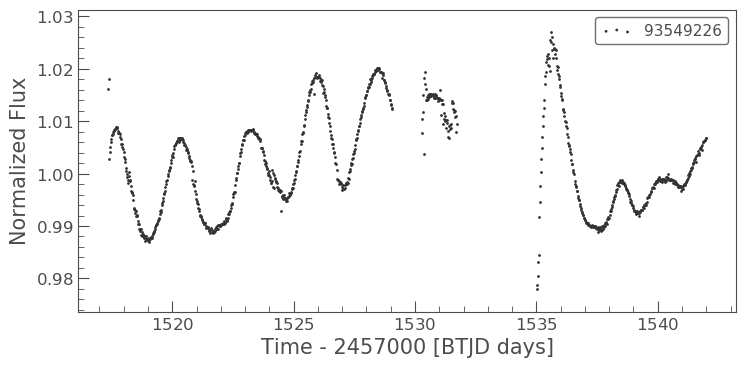

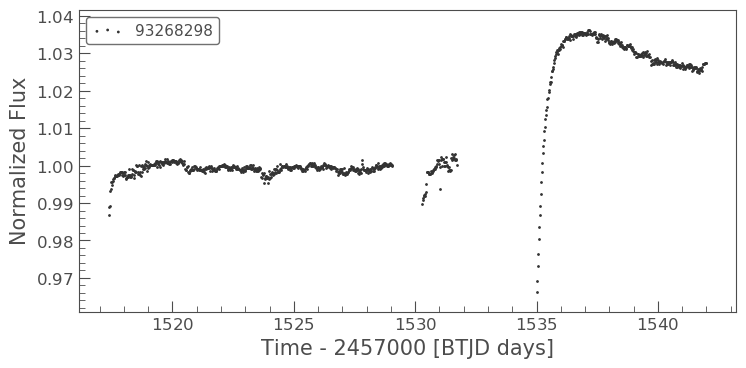

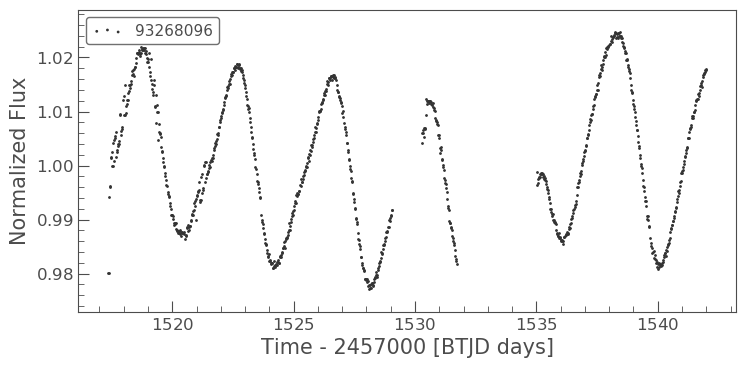

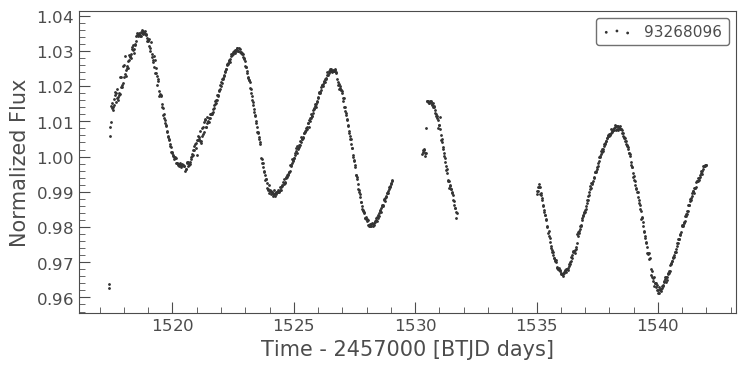

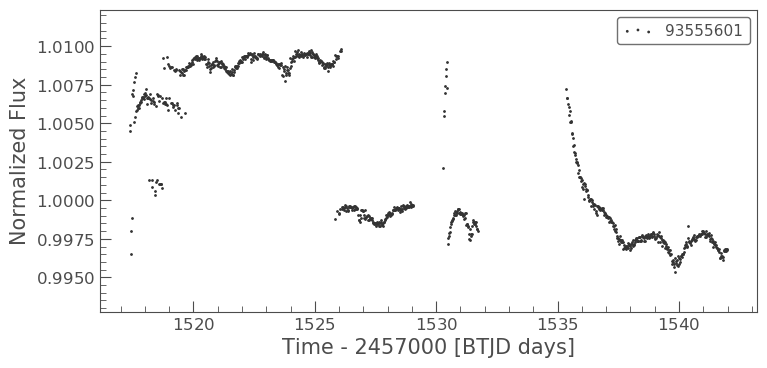

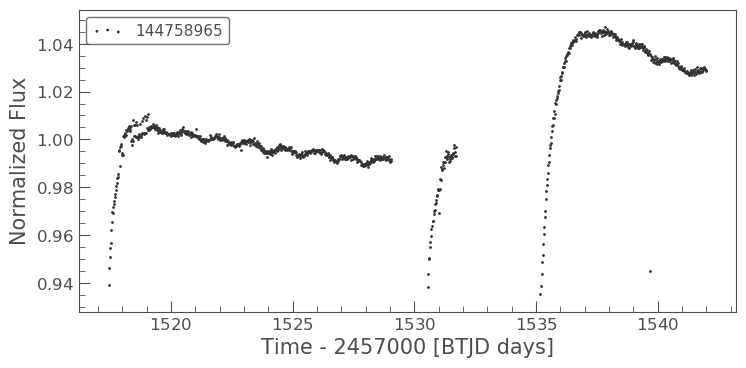

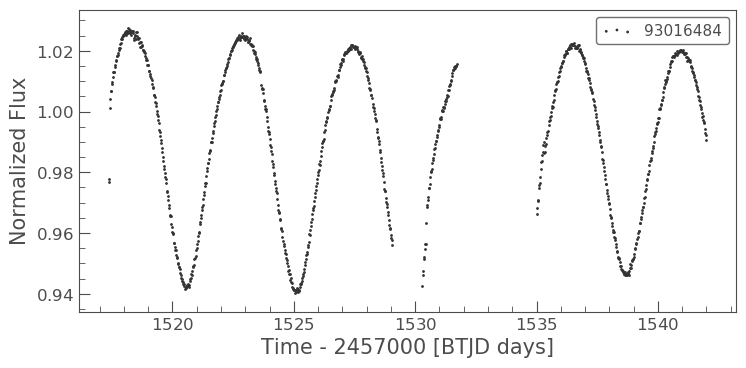

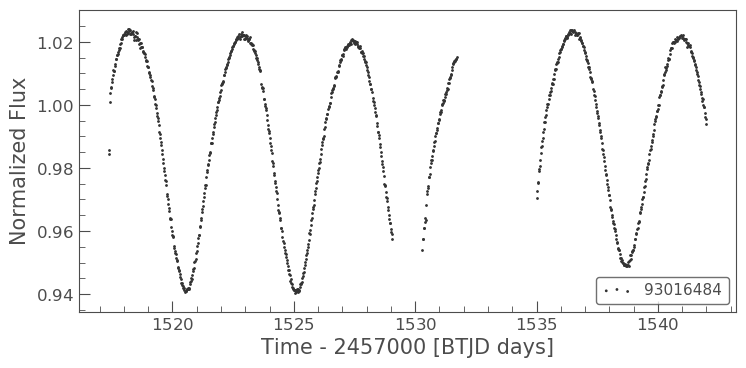

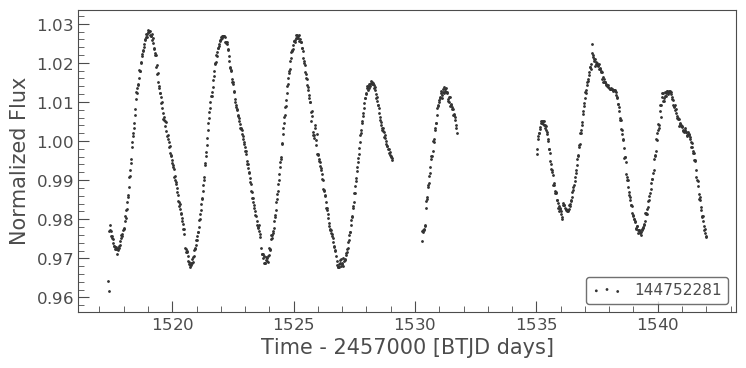

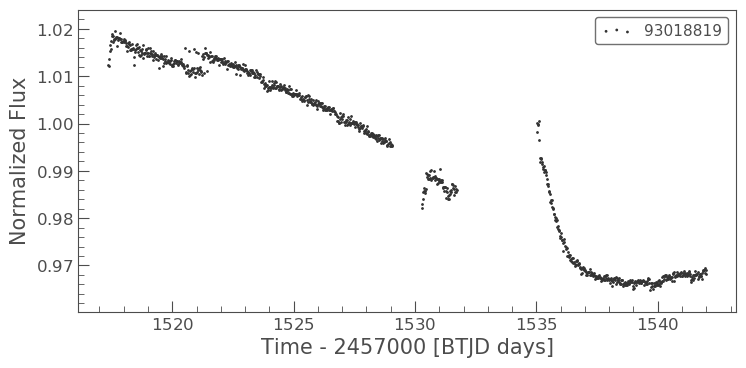

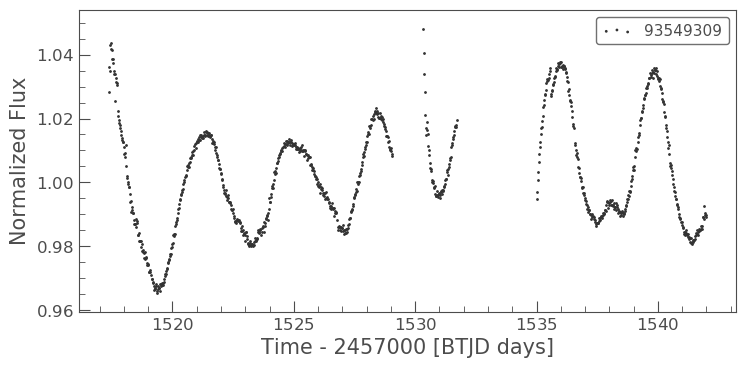

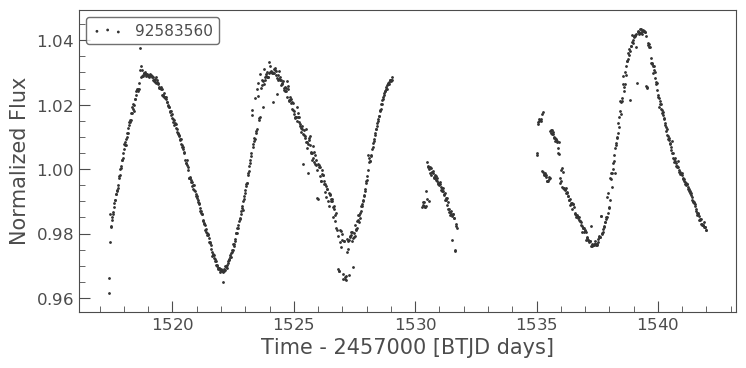

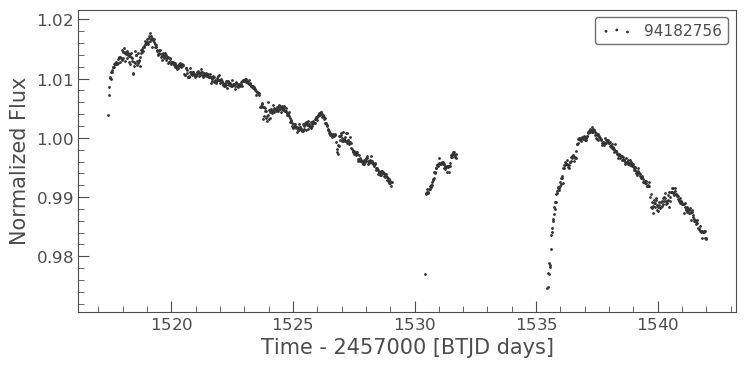

In [16]:
amplitude_top_quarter = np.percentile(amplitudes, 75)
sigmas_top_quarter = np.percentile(sigmas, 25)

indx = np.where((amplitudes > amplitude_top_quarter) & (sigmas < sigmas_top_quarter))[0]

# Get sample light curve
for index in indx:
    fits_path = fits_paths[index]

    # Import sample FITS Light Curve, remove outliers, and long term trends
    ticid, ap_type = decode_filename(fits_path)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",category=LightkurveWarning)
        cleared_lc, clipped_mask = open_lc(fits_path).get_lightcurve('FLUX').normalize().remove_outliers(sigma=outlier_sigma, return_mask=True)
    cleared_lc.scatter()
    plt.show()